# AMPD - Automatic Multiscale Peak Detection

This implementation is based on the AMPD algorithm described by Scholkmann et al.,
    which detects peaks in a signal using a multiscale approach and local scalogram matrix.

In [174]:
import cedalion.nirs
from cedalion import units
from cedalion.sigproc import quality
from cedalion.sigproc.frequency import freq_filter
import cedalion.xrutils as xrutils
from cedalion.datasets import get_fingertapping_snirf_path
import time
import numpy as np
import xarray as xr
from cedalion.sigproc.physio import ampd, ampd_orig
import matplotlib.pyplot as plt

xr.set_options(display_max_rows=3, display_values_threshold=50)
np.set_printoptions(precision=4)

### Loading raw CW-NIRS data from a SNIRF file
This notebook uses a finger-tapping dataset in BIDS layout provided by [Rob Luke](https://github.com/rob-luke/BIDS-NIRS-Tapping). It can can be downloaded via `cedalion.datasets`.

Load amplitude data from the snirf file.

In [175]:
path_to_snirf_file = get_fingertapping_snirf_path()

recordings = cedalion.io.read_snirf(path_to_snirf_file)
rec = recordings[0]  # there is only one NirsElement in this snirf file...
amp = rec["amp"]  # ... which holds amplitude data

# restrict to first 60 seconds and fill in missing units
amp = amp.sel(time=amp.time < 60)
times = amp.time.values * 1000
# print(amp.time.values[-1] / 60, len(times))


In [176]:

# collection of utility functions

def isolate_channel(amplitudes: xr.DataArray, channel_name: str):
    channels = amplitudes.channel
    channel_mask = xrutils.mask(channels, True)
    channel_mask = channel_mask.where(channels == channel_name, False)
    isolated_amplitudes, drop_list = quality.prune_ch(amplitudes, [channel_mask], "all")

    return isolated_amplitudes


def normalize(sig):
    min_val = np.min(sig)
    max_val = np.max(sig)
    return (sig - min_val) / (max_val - min_val)


def plot_peaks(signal, s_times, s_peaks, label, title='peaks'):
    fig, ax = plt.subplots(1, 1, figsize=(24, 8))
    ax.plot(s_times, signal, label=label)

    for ind, peak in enumerate(s_peaks):
        if peak > 0:
            ax.axvline(x=peak, color='black', linestyle='--', linewidth=1)

    plt.title(title)


def filter_signal(amplitudes):
    return freq_filter(amplitudes, 0.5 * units.Hz, 3 * units.Hz, 2)


In [177]:
# isolate one channel to run the AMPD on. Just to run it faster
#amp = isolate_channel(amp, 'S1D1')
amp
# filter the signal to remove noise
# amp = filter_signal(amp)

Magnitude,[[[0.0913686 0.0909875 0.0910225 ... 0.0903297 0.090175 0.0899268] [0.1856806 0.186377 0.1836514 ... 0.184885 0.1850145 0.1846866]] [[0.227516 0.2297024 0.2261366 ... 0.2241381 0.2243378 0.2256896] [0.6354927 0.637668 0.6298023 ... 0.6222512 0.6236847 0.627199]] [[0.1064704 0.1066212 0.1053444 ... 0.106494 0.1061651 0.1056465] [0.2755033 0.2761615 0.2727006 ... 0.2736698 0.2742193 0.2759685]] ... [[0.2027881 0.1996586 0.2004866 ... 0.1998214 0.2007051 0.202647] [0.4666358 0.4554404 0.4561614 ... 0.448159 0.4511331 0.4540838]] [[0.4885007 0.4802285 0.4818338 ... 0.5004812 0.5035935 0.5044765] [0.8457658 0.825988 0.8259648 ... 0.8385809 0.8441086 0.8474942]] [[0.6304559 0.6284427 0.6287045 ... 0.637311 0.6379823 0.6392407] [1.2285622 1.2205907 1.2190002 ... 1.2232131 1.2258861 1.2278113]]]
Units,dimensionless


In [178]:


# use the optimized AMPD to find the peaks
t1_opt = time.perf_counter()
peaks = ampd(amp)
t2_opt = time.perf_counter()

C:\Users\isawa\anaconda3\envs\cedalion\Lib\site-packages\xarray\core\variable.py:338: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


docs for peaks

In [179]:
peaks

<xarray.DataArray (channel: 28, wavelength: 2, time: 469)> Size: 105kB
array([[[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates: (3/6)
  * time        (time) float64 4kB 0.0 0.128 0.256 0.384 ... 59.65 59.78 59.9
    samples     (time) int32 2kB 0 1 2 3 4 5 6 7 ... 462 463 464 465 466 467 468
    ...          ...
  * wavelength  (wavelength) float64 16B 760.0 850.0
Attributes:
    data_type_group:  unprocessed raw

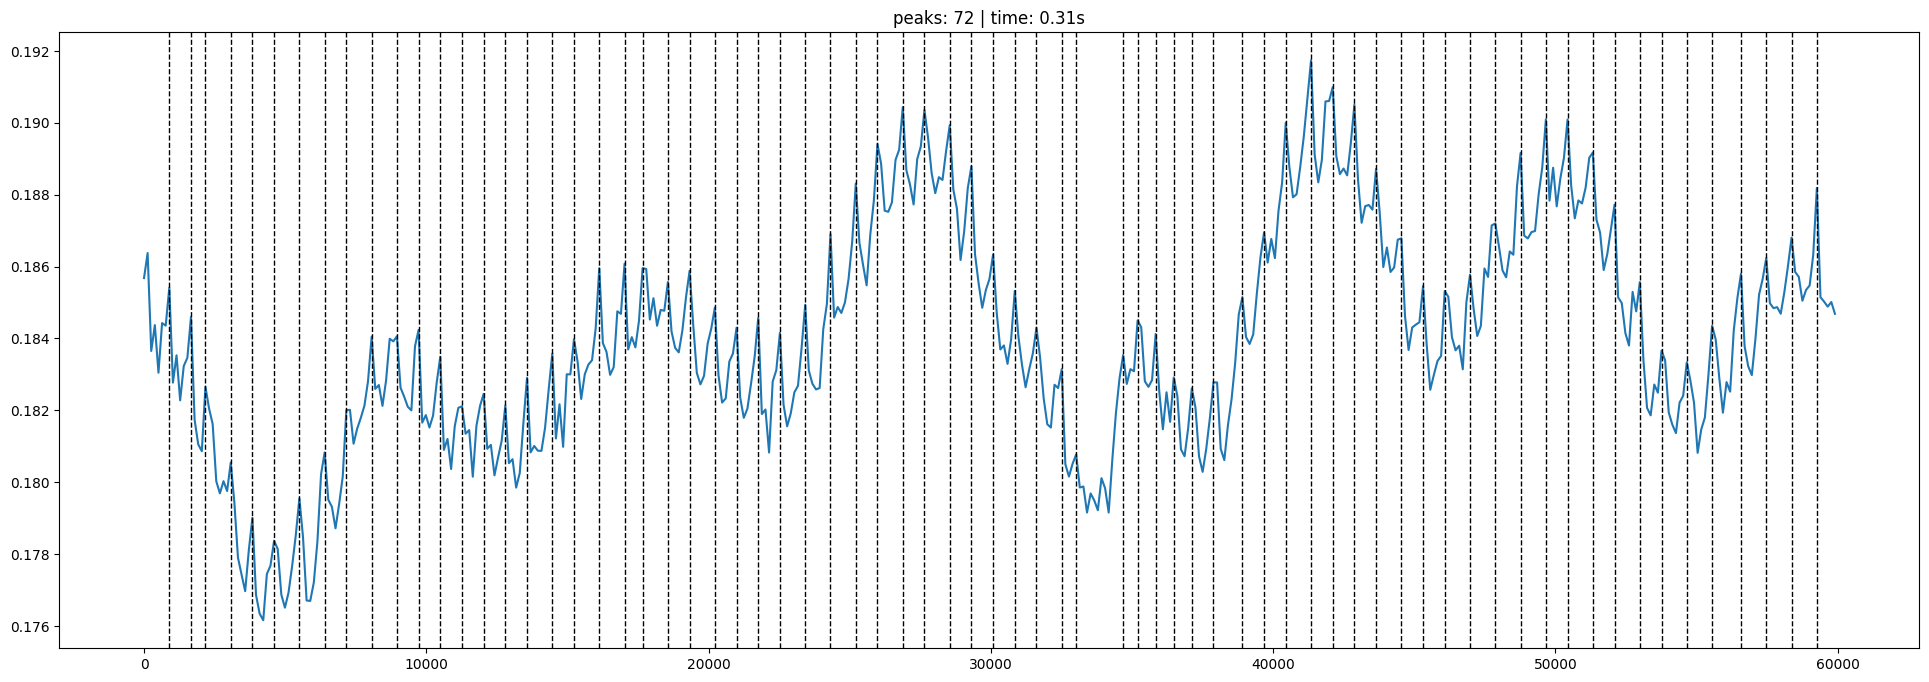

In [182]:

# select the first channel for displaying the results
channel = "S1D1" #amp.channel[0]
channel_data = amp.sel(channel=channel)

# retrieve the peaks for that channel. peaks contains lists for the channel and both wavelengths 
# where peaks are represented by 1 and non-peaks are 0
peak_indices = peaks.sel(channel=channel)

# extract the timestamps of the identified peaks for one wavelength
peak_times = times * peak_indices.values[1]
peak_times = [pt for pt in peak_times if pt > 0]

# for plotting prepare the signal for the same wavelength
signal = channel_data.values[1]

# plot the signal and the peaks calculated by the optimized AMPD
plot_peaks(signal, times, peak_times, channel, f"peaks: {len(peak_times)} | time: {round(t2_opt - t1_opt, 3)}s")
